# Lorenz 96 tutorial

This is the EasySurrogate tutorial applied to the Lorenz 96 two-layer model equations:

\begin{align}
    \frac{d x^{(k)}}{d t} = 
    x^{(k-1)}\left(x^{(k+1)} - x^{(k-2)}\right) - x^{(k)} - F + r^{(k)} \nonumber\\
    %
    r^{(k)} := \frac{h_x}{J}\sum_{j=1}^L y^{(j,k)} \nonumber \\
    %
    \frac{d y^{(j, k)}}{d t} = 
    \frac{1}{\epsilon}\left[y^{(j+1, k)}\left(y^{(j-1, k)} - y^{(j+2, k)}\right) - y^{(j, k)} + h_y 
    x^{(k)}\right].
    %
\end{align}

Our goal is to create a Quantized Softmax Network (QSN) surrogate for the subgrid-scale terms $r_k$, denote as $\widetilde{r}_k$, such that we can solve the following reduced one-layer system:

\begin{align}
    \frac{d \widetilde{x}^{(k)}}{d t} = 
    \widetilde{x}^{(k-1)}\left(\widetilde{x}^{(k+1)} - \widetilde{x}^{(k-2)}\right) - \widetilde{x}^{(k)} - F + \widetilde{r}^{(k)}
    %
\end{align}

There are four main steps, namely

* Running the full two-layer model to generate training data
* Train the QSN surrogate
* Running the macroscopic one-layer model with a microscopic QSN surrogate $\widetilde{r}_k$
* Post process the results

Running this tutorial should take approximately 30 minutes if done on your local machine. If you're runninig this on Binder, training the QSN network might be slower.

In [1]:
import easysurrogate as es
import L96 as solver
import numpy as np
import matplotlib.pyplot as plt

## Generate the training data

Here, we create a time loop over the L96 two-layer model, which can be found in L96.py. We are storing the macroscopic states $x_k, k=1\cdots,K$, and the subgrid-scale data $r_k, k=1\cdots,K$ inside the EasySurrogate Campaign object. Once we exit the time loop, you'll be asked to store this data somewhere on your local hard drive in a HDF5 file.

t = 0.0 of 1000.0
t = 10.0 of 1000.0
t = 20.0 of 1000.0
t = 30.0 of 1000.0
t = 40.0 of 1000.0
t = 50.0 of 1000.0
t = 60.0 of 1000.0
t = 70.0 of 1000.0
t = 80.0 of 1000.0
t = 90.0 of 1000.0
t = 100.0 of 1000.0
t = 110.0 of 1000.0
t = 120.0 of 1000.0
t = 130.0 of 1000.0
t = 140.0 of 1000.0
t = 150.0 of 1000.0
t = 160.0 of 1000.0
t = 170.0 of 1000.0
t = 180.0 of 1000.0
t = 190.0 of 1000.0
t = 200.0 of 1000.0
t = 210.0 of 1000.0
t = 220.0 of 1000.0
t = 230.0 of 1000.0
t = 240.0 of 1000.0
t = 250.0 of 1000.0
t = 260.0 of 1000.0
t = 270.0 of 1000.0
t = 280.0 of 1000.0
t = 290.0 of 1000.0
t = 300.0 of 1000.0
t = 310.0 of 1000.0
t = 320.0 of 1000.0
t = 330.0 of 1000.0
t = 340.0 of 1000.0
t = 350.0 of 1000.0
t = 360.0 of 1000.0
t = 370.0 of 1000.0
t = 380.0 of 1000.0
t = 390.0 of 1000.0
t = 400.0 of 1000.0
t = 410.0 of 1000.0
t = 420.0 of 1000.0
t = 430.0 of 1000.0
t = 440.0 of 1000.0
t = 450.0 of 1000.0
t = 460.0 of 1000.0
t = 470.0 of 1000.0
t = 480.0 of 1000.0
t = 490.0 of 1000.0
t = 500.0 o

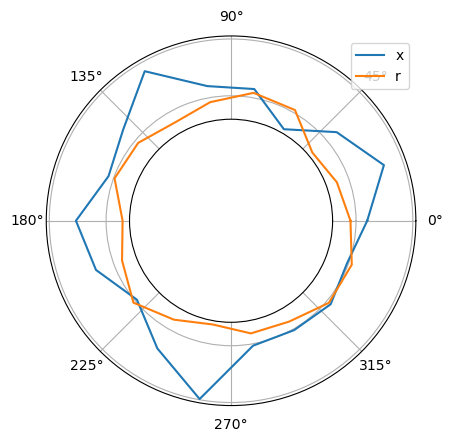

In [2]:
# Create an EasySurrogate campaign
campaign = es.Campaign()

# Time step
dt = 0.01

# Create a solver for the two-layer Lorenz 96 model
l96 = solver.L96(dt)

# Get the initial condition of X and the right-hand side of the X ODE
X_n, f_nm1 = l96.initial_conditions()

# Simulation time
t_end = 1000.0
t = np.arange(0.0, t_end, dt)

# Start time integration
for idx, t_i in enumerate(t):
    
    # Integrate the two-layer model in time
    X_np1, f_n = l96.step(X_n, f_nm1)

    # Update variables
    X_n = X_np1
    f_nm1 = f_n
    
    # Store data
    snapshot = {'X_n': X_n, 'r_n': l96.r_n}
    campaign.accumulate_data(snapshot)

    if np.mod(idx, 1000) == 0:
        print('t =', np.around(t_i, 1), 'of', t_end)

#store the accumulated data to an HDF5 file
campaign.store_accumulated_data(file_path='/tmp/L96_train.hdf5')

#plot the X solution and the subgrid-scale term at the final time
l96.plot_solution()

## Train a QSN surrogate

Here we train the QSN surrogate on the first half of the generated training data. Furthermore, we will use the `get_classification_error` subroutine from the `QSN_analysis` class to compute the relative classification error for each spartial point k=1,...,K.

In [3]:
# Load HDF5 data frame
data_frame_train = campaign.load_hdf5_data(file_path='/tmp/L96_train.hdf5')

# Supervised training data set
features = data_frame_train['X_n']
target = data_frame_train['r_n']

# create Quantized Softmax Network surrogate
surrogate = es.methods.QSN_Surrogate()

# create time-lagged features
lags = [range(1, 10)]

# train the surrogate on the data
n_iter = 20000
surrogate.train(features, target, n_iter, lags=lags, n_layers=4, n_neurons=256,
                batch_size=512, test_frac=0.5)

campaign.add_app(name='L96_campaign', surrogate=surrogate)
campaign.save_state(file_path='/tmp/campaign.pickle')

# QSN analysis object
analysis = es.analysis.QSN_analysis(surrogate)
analysis.get_classification_error(index=np.arange(0, 10000))

Loaded X_n
Loaded r_n
Creating Quantized Softmax Object
Creating Feature Engineering object
Using  50000/100000 samples to train the ML model
Creating time-lagged training data...
done preparing data
Neural net parameters
Number of layers = 4
Number of features = 162
Loss function = cross_entropy
Number of neurons per hidden layer = 256
Number of output neurons = 180
Activation = ['linear', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'linear']
This neural network has 219572 weights.
Training Quantized Softmax Network...
Batch 0 learning rate 0.001 loss: 21884.256620299107
Batch 1000 learning rate 0.001 loss: 2810.479443741616
Batch 2000 learning rate 0.001 loss: 1887.1328686696388
Batch 3000 learning rate 0.001 loss: 1401.3508350624131


## Run the one-layer L96 model with QSN surrogate

If we specify `r_n` in the `step` routine, the second, microscopic layer is not solved, and `r_n` is used as a subgrid-scale surrogate. Below `r_n` is computed using the QSN surrogate.

In [4]:
# #get the initial condition of X and the right-hand side of the X ODE
X_n, f_nm1 = l96.initial_conditions()
r_n = np.zeros(l96.K)

# start time integration
for idx, t_i in enumerate(t):
    
    if idx > campaign.surrogate.max_lag:
        # Predict the subgrid scale term with the QSN surrogate
        r_n = campaign.surrogate.predict(X_n)

    # Integrate the one-layer model in time
    X_np1, f_n = l96.step(X_n, f_nm1, r_n=r_n)

    # Update variables
    X_n = X_np1
    f_nm1 = f_n
    
    # Store data
    snapshot = {'X_n': X_n, 'r_n': r_n}
    campaign.accumulate_data(snapshot)

    if np.mod(idx, 1000) == 0:
        print('t =', np.around(t_i, 1), 'of', t_end)

#store the accumulated data to an HDF5 file
campaign.store_accumulated_data(file_path='/tmp/L96_test.hdf5')


t = 0.0 of 1000.0
t = 10.0 of 1000.0
t = 20.0 of 1000.0
t = 30.0 of 1000.0
t = 40.0 of 1000.0
t = 50.0 of 1000.0
t = 60.0 of 1000.0
t = 70.0 of 1000.0
t = 80.0 of 1000.0
t = 90.0 of 1000.0
t = 100.0 of 1000.0
t = 110.0 of 1000.0
t = 120.0 of 1000.0
t = 130.0 of 1000.0
t = 140.0 of 1000.0
t = 150.0 of 1000.0
t = 160.0 of 1000.0
t = 170.0 of 1000.0
t = 180.0 of 1000.0
t = 190.0 of 1000.0
t = 200.0 of 1000.0
t = 210.0 of 1000.0
t = 220.0 of 1000.0
t = 230.0 of 1000.0
t = 240.0 of 1000.0
t = 250.0 of 1000.0
t = 260.0 of 1000.0
t = 270.0 of 1000.0
t = 280.0 of 1000.0
t = 290.0 of 1000.0
t = 300.0 of 1000.0
t = 310.0 of 1000.0
t = 320.0 of 1000.0
t = 330.0 of 1000.0
t = 340.0 of 1000.0
t = 350.0 of 1000.0
t = 360.0 of 1000.0
t = 370.0 of 1000.0
t = 380.0 of 1000.0
t = 390.0 of 1000.0
t = 400.0 of 1000.0
t = 410.0 of 1000.0
t = 420.0 of 1000.0
t = 430.0 of 1000.0
t = 440.0 of 1000.0
t = 450.0 of 1000.0
t = 460.0 of 1000.0
t = 470.0 of 1000.0
t = 480.0 of 1000.0
t = 490.0 of 1000.0
t = 500.0 o

##  Post processing

We will not have pathwise exact trajectories once we replace the exact subgrid scale term with a surrogate. Below, we will therefore use `QSN_analysis` to compute the statistical equivalence between the two-layer reference model and the one-layer model with QSN surrogate. We start by comparing the probability density functions:

Loaded X_n
Loaded r_n
Creating QSN_analysis object
Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.


done


findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


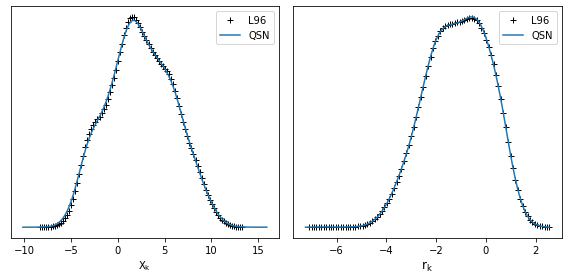

In [5]:
# load the prediction 
data_frame_qsn = campaign.load_hdf5_data(file_path='/tmp/L96_test.hdf5')

# load reference data
X_ref = data_frame_train['X_n']
r_ref = data_frame_train['r_n']

# load data of QSN surrogate
X_qsn = data_frame_qsn['X_n']
r_qsn = data_frame_qsn['r_n']

# Create a QSN analysis object
analysis = es.analysis.QSN_analysis(campaign.surrogate)

#############
# Plot PDFs #
#############

burn = 0; subsample = 10
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(121, xlabel=r'$X_k$')
X_dom_surr, X_pdf_surr = analysis.get_pdf(X_qsn[:, 0])
X_dom, X_pdf = analysis.get_pdf(X_ref[:, 0])
ax.plot(X_dom, X_pdf, 'k+', label='L96')
ax.plot(X_dom_surr, X_pdf_surr, label='QSN')
plt.yticks([])
plt.legend(loc=0)

ax = fig.add_subplot(122)
ax.set_xlabel(r'$r_k$', fontsize=12)
r_dom_surr, r_pdf_surr = analysis.get_pdf(r_qsn[burn:-1:subsample].flatten())
r_dom, r_pdf = analysis.get_pdf(r_ref[burn:-1:subsample].flatten())
ax.plot(r_dom, r_pdf, 'k+', label='L96')
ax.plot(r_dom_surr, r_pdf_surr, label='QSN')
plt.yticks([])
plt.legend(loc=0)

plt.tight_layout()

Here, we will compare the autocorrelations functions (acfs) of the reference two-layer system, and those of the system with QSN surrogate. We will average the acfs over all spatial points.

In [ ]:
#############
# Plot ACFs #
#############

# the number of time steps to compute the acf over
acf_lag = 1000

fig = plt.figure(figsize=[8, 4])
ax1 = fig.add_subplot(121, ylabel=r'$\mathrm{ACF}\;X_n$', xlabel='time')
ax2 = fig.add_subplot(122, ylabel=r'$\mathrm{ACF}\;r_n$', xlabel='time')

acf_X_ref = np.zeros(acf_lag - 1)
acf_X_sol = np.zeros(acf_lag - 1)
acf_r_ref = np.zeros(acf_lag - 1)
acf_r_sol = np.zeros(acf_lag - 1)

# average over all K spatial points
K = l96.K
for k in range(K):
    print('k=%d' % k)
    acf_X_ref += 1 / K * analysis.auto_correlation_function(X_ref[burn:, k], max_lag=acf_lag)
    acf_X_sol += 1 / K * analysis.auto_correlation_function(X_qsn[burn:, k], max_lag=acf_lag)

    acf_r_ref += 1 / K * analysis.auto_correlation_function(r_ref[burn:, k], max_lag=acf_lag)
    acf_r_sol += 1 / K * analysis.auto_correlation_function(r_qsn[burn:, k], max_lag=acf_lag)

dom_acf = np.arange(acf_lag - 1) * dt
ax1.plot(dom_acf, acf_X_ref, 'k+', label='L96')
ax1.plot(dom_acf, acf_X_sol, label='QSN')

ax2.plot(dom_acf, acf_r_ref, 'k+', label='L96')
ax2.plot(dom_acf, acf_r_sol, label='QSN')
leg = plt.legend(loc=0)

plt.tight_layout()

k=0
Computing auto-correlation function
done
E-folding index = 24
Computing auto-correlation function
done
E-folding index = 24
Computing auto-correlation function
done
E-folding index = 26
Computing auto-correlation function
done
E-folding index = 25
k=1
Computing auto-correlation function
done
E-folding index = 24
Computing auto-correlation function
done
E-folding index = 24
Computing auto-correlation function
done
E-folding index = 26
Computing auto-correlation function
